### **Resumo do Experimento #3: U-Net com Data Augmentation**

* **Objetivo:** Avaliar o impacto de Data Augmentation na performance e robustez do modelo, mantendo a base de hiperparâmetros do experimento anterior.

* **Arquitetura do Modelo:**
    * U-Net

* **Configuração do Treinamento:**
    * **Função de Perda:** Dice + BCE Loss (`DiceBCELoss`)
    * **Otimizador:** Adam
    * **Taxa de Aprendizado Inicial:** `1e-4`
    * **Batch Size:** `4`
    * **Número Máximo de Épocas:** `75`

* **Agendador de Taxa de Aprendizado (Scheduler):**
    * **Estratégia:** `ReduceLROnPlateau`
    * **Métrica Monitorada:** `Validation IoU`
    * **Paciência:** `5` épocas
    * **Fator de Redução:** `0.2`

* **Data Augmentation (aplicada apenas no treino):**
    * Resize para `256x256`
    * Rotação Aleatória (limite de 35 graus)
    * Flip Horizontal Aleatório
    * Flip Vertical Aleatório
    * Variação de Cor Aleatória (brilho, contraste, saturação, matiz)
    * Normalização

In [1]:
# CELULA 1
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures
import csv
import pandas as pd
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 

In [2]:
# CELULA 2
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [3]:
# CELULA 3
# --- Configurações do Ambiente e Caminhos ---
# Certifique-se de que este caminho aponta para os dados pré-processados
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" 
MODEL_SAVE_PATH = "./tomato_unet_best.pth"  # O modelo será salvo com este nome
CSV_LOG_PATH = "./training_log.csv"      # O log será salvo aqui
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# --- Hiperparâmetros para o Treinamento v2 ---
config = {
    "LEARNING_RATE": 1e-4,       # LR inicial. O scheduler vai ajustá-lo.
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 75,            # Aumentamos para dar mais tempo para o modelo aprender.
    "IMAGE_HEIGHT": 256,
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam",
    "LOSS_FUNCTION": "DiceBCE"
}

# NOVO: Configuração do Agendador de Taxa de Aprendizado (Scheduler)
scheduler_config = {
    "factor": 0.2,               # Fator de redução do LR (new_lr = lr * factor). 0.1 ou 0.2 são comuns.
    "patience": 5,               # Nº de épocas sem melhora no val_iou para reduzir o LR.
    "min_lr": 1e-7,              # Taxa de aprendizado mínima.
    "verbose": True              # Imprime uma mensagem quando o LR é atualizado.
}

Usando o dispositivo: cuda


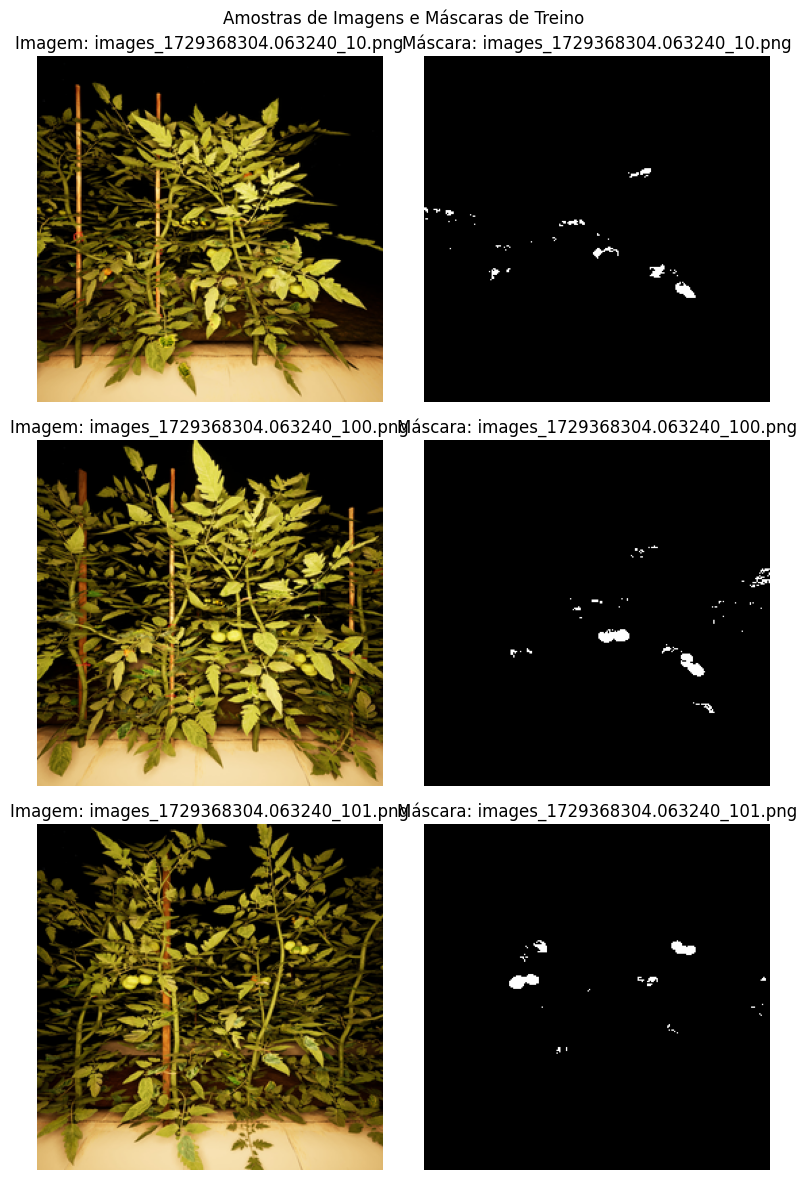

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 2469.15it/s]


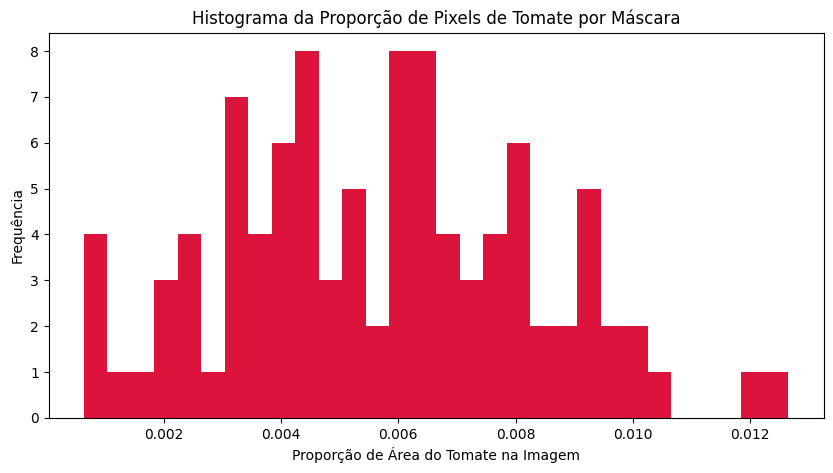

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [4]:
# CELULA 4
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [5]:
# ===================================================================
# CÉLULA 5: DATASET COM DATA AUGMENTATION (VERSÃO FINAL CORRIGIDA)
# ===================================================================
# 1. DEFINIÇÃO DA CLASSE DE DATASET CORRETA
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Lógica para encontrar a máscara correspondente
        base_name, _ = os.path.splitext(img_name)
        mask_path = os.path.join(self.mask_dir, base_name + ".png")
        if not os.path.exists(mask_path):
            # Tenta outras extensões ou o mesmo nome se o .png não for encontrado
            mask_path_alt = os.path.join(self.mask_dir, img_name)
            if os.path.exists(mask_path_alt):
                mask_path = mask_path_alt
            else:
                raise FileNotFoundError(f"Máscara não encontrada para a imagem {img_name}")

        # Carrega a imagem como array numpy, que é o que albumentations espera
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        
        # Garante que a máscara seja binária (0 ou 1)
        mask[mask > 0] = 1.0

        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        # Albumentations com ToTensorV2 já retorna o formato C, H, W
        # A máscara precisa de uma dimensão de canal para a loss
        return image, mask.unsqueeze(0)

# 2. DEFINIÇÃO DAS TRANSFORMAÇÕES COM ALBUMENTATIONS
train_transforms = A.Compose(
    [
        # A.Resize(height=config["IMAGE_HEIGHT"], width=config["IMAGE_WIDTH"], interpolation=cv2.INTER_NEAREST),
        A.Rotate(limit=35, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.ColorJitter(p=0.5, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        # A.Resize(height=config["IMAGE_HEIGHT"], width=config["IMAGE_WIDTH"], interpolation=cv2.INTER_NEAREST),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

# 3. CRIAÇÃO DOS DATASETS E DATALOADERS
print("Criando Datasets e DataLoaders com Data Augmentation...")
try:
    train_ds = TomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        transform=train_transforms
    )
    val_ds = TomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        transform=val_transforms
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=0, # Pode ajustar (0, 2, 4...)
        pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    print("-> Datasets e DataLoaders criados com sucesso!")
    print(f"   Dataset de treino: {len(train_ds)} amostras.")
    print(f"   Dataset de validação: {len(val_ds)} amostras.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

Criando Datasets e DataLoaders com Data Augmentation...
-> Datasets e DataLoaders criados com sucesso!
   Dataset de treino: 17138 amostras.
   Dataset de validação: 4229 amostras.


In [6]:
# CELULA 6
# Bloco de convolução dupla usado na U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# Implementação da U-Net
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Down path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (Up path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Teste rápido para ver se a arquitetura está correta
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
x = torch.randn(2, 3, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"]).to(DEVICE)
preds = model(x)
assert preds.shape == (2, 1, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"])
print("Arquitetura U-Net carregada com sucesso!")

Arquitetura U-Net carregada com sucesso!


In [7]:
# CELULA 7
# Métrica 1: Dice Coefficient / F1 Score
# Essencial para artigos de segmentação
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs) # Aplicar sigmoid para ter probabilidades

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Métrica 2: Intersection over Union (IoU) / Jaccard Index
# Também essencial
def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) if len(y.shape) == 3 else y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calcular Dice e IoU por lote e somar
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)


    accuracy = num_correct/num_pixels*100
    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)

    print(f"Acurácia de pixels: {accuracy:.2f}%")
    print(f"Dice Score (Média): {avg_dice:.4f}")
    print(f"IoU/Jaccard (Média): {avg_iou:.4f}")

    model.train()
    return avg_iou, avg_dice

# Escolher a função de perda com base na configuração
if config["LOSS_FUNCTION"] == "BCE":
    loss_fn = nn.BCEWithLogitsLoss()
elif config["LOSS_FUNCTION"] == "Dice":
    loss_fn = DiceLoss()
elif config["LOSS_FUNCTION"] == "DiceBCE":
    class DiceBCELoss(nn.Module):
        def __init__(self, weight=None, size_average=True):
            super(DiceBCELoss, self).__init__()
        def forward(self, inputs, targets, smooth=1):
            inputs_sig = torch.sigmoid(inputs)
            inputs_flat = inputs_sig.view(-1)
            targets_flat = targets.view(-1)
            intersection = (inputs_flat * targets_flat).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
            bce = nn.BCEWithLogitsLoss()(inputs, targets)
            return bce + dice_loss
    loss_fn = DiceBCELoss()

# Escolher o otimizador
if config["OPTIMIZER"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
elif config["OPTIMIZER"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=config["LEARNING_RATE"], momentum=0.9)

print(f"Otimizador: {config['OPTIMIZER']}, Função de Perda: {config['LOSS_FUNCTION']}")

Otimizador: Adam, Função de Perda: DiceBCE


In [8]:
# CELULA 8
# Função para o loop de uma época
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        # Adicionar dimensão de canal para a máscara
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

# --- INÍCIO DO TREINAMENTO ---
history = {'train_loss': [], 'val_iou': [], 'val_dice': []}
best_val_iou = -1.0
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
scaler = torch.cuda.amp.GradScaler()

# Instancia o Agendador de Taxa de Aprendizado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'max', # Queremos maximizar o IoU
    factor=scheduler_config["factor"],
    patience=scheduler_config["patience"],
    min_lr=scheduler_config["min_lr"],
    verbose=scheduler_config["verbose"]
)

# --- INICIALIZAÇÃO DO LOG ---
best_val_iou = -1.0

# Cria o arquivo CSV e escreve o cabeçalho
with open(CSV_LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    # MUDANÇA 1: Adicionada a coluna 'duration_sec' ao cabeçalho
    writer.writerow(['epoch', 'train_loss', 'val_iou', 'val_dice', 'learning_rate', 'duration_sec'])
print(f"Arquivo de log criado em: {CSV_LOG_PATH}")

# --- LOOP DE TREINAMENTO ---
print("\n--- Iniciando o Treinamento Final ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    model.train()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    model.eval()
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    
    # Calcula a duração da época ANTES de imprimir, para poder salvar no log
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Imprime o resumo da época
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f} | LR: {current_lr:.2e}")
    print(f"Validação -> IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

    scheduler.step(val_iou)

    # Salva os dados da época no arquivo CSV
    with open(CSV_LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        # MUDANÇA 2: Adicionada a variável epoch_duration à linha salva
        writer.writerow([epoch+1, train_loss, val_iou.item(), val_dice.item(), current_lr, epoch_duration])

    # Salva o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo! **")

print("--- Treinamento Concluído ---")


Arquivo de log criado em: ./training_log.csv

--- Iniciando o Treinamento Final ---


100%|██████████| 4285/4285 [08:03<00:00,  8.86it/s, loss=0.403]


Acurácia de pixels: 99.68%
Dice Score (Média): 0.6929
IoU/Jaccard (Média): 0.5426

--- ÉPOCA 1/75 ---
Loss de Treino: 0.7257 | LR: 1.00e-04
Validação -> IoU: 0.5426 | Dice: 0.6929
Duração da Época: 534.97 segundos
** Novo melhor IoU: 0.5426. Modelo salvo! **


100%|██████████| 4285/4285 [08:01<00:00,  8.90it/s, loss=0.445]


Acurácia de pixels: 99.70%
Dice Score (Média): 0.7364
IoU/Jaccard (Média): 0.5920

--- ÉPOCA 2/75 ---
Loss de Treino: 0.3482 | LR: 1.00e-04
Validação -> IoU: 0.5920 | Dice: 0.7364
Duração da Época: 532.90 segundos
** Novo melhor IoU: 0.5920. Modelo salvo! **


100%|██████████| 4285/4285 [07:57<00:00,  8.97it/s, loss=0.398]


Acurácia de pixels: 99.74%
Dice Score (Média): 0.7566
IoU/Jaccard (Média): 0.6195

--- ÉPOCA 3/75 ---
Loss de Treino: 0.3154 | LR: 1.00e-04
Validação -> IoU: 0.6195 | Dice: 0.7566
Duração da Época: 528.88 segundos
** Novo melhor IoU: 0.6195. Modelo salvo! **


100%|██████████| 4285/4285 [07:59<00:00,  8.94it/s, loss=0.356]


Acurácia de pixels: 99.74%
Dice Score (Média): 0.7678
IoU/Jaccard (Média): 0.6325

--- ÉPOCA 4/75 ---
Loss de Treino: 0.2973 | LR: 1.00e-04
Validação -> IoU: 0.6325 | Dice: 0.7678
Duração da Época: 530.52 segundos
** Novo melhor IoU: 0.6325. Modelo salvo! **


100%|██████████| 4285/4285 [08:15<00:00,  8.65it/s, loss=0.239]


Acurácia de pixels: 99.76%
Dice Score (Média): 0.7846
IoU/Jaccard (Média): 0.6525

--- ÉPOCA 5/75 ---
Loss de Treino: 0.2813 | LR: 1.00e-04
Validação -> IoU: 0.6525 | Dice: 0.7846
Duração da Época: 546.78 segundos
** Novo melhor IoU: 0.6525. Modelo salvo! **


100%|██████████| 4285/4285 [08:19<00:00,  8.59it/s, loss=0.269] 


Acurácia de pixels: 99.77%
Dice Score (Média): 0.7945
IoU/Jaccard (Média): 0.6655

--- ÉPOCA 6/75 ---
Loss de Treino: 0.2713 | LR: 1.00e-04
Validação -> IoU: 0.6655 | Dice: 0.7945
Duração da Época: 550.26 segundos
** Novo melhor IoU: 0.6655. Modelo salvo! **


100%|██████████| 4285/4285 [08:01<00:00,  8.90it/s, loss=0.244]


Acurácia de pixels: 99.77%
Dice Score (Média): 0.7987
IoU/Jaccard (Média): 0.6712

--- ÉPOCA 7/75 ---
Loss de Treino: 0.2611 | LR: 1.00e-04
Validação -> IoU: 0.6712 | Dice: 0.7987
Duração da Época: 532.46 segundos
** Novo melhor IoU: 0.6712. Modelo salvo! **


100%|██████████| 4285/4285 [08:02<00:00,  8.88it/s, loss=0.147]


Acurácia de pixels: 99.78%
Dice Score (Média): 0.8078
IoU/Jaccard (Média): 0.6831

--- ÉPOCA 8/75 ---
Loss de Treino: 0.2545 | LR: 1.00e-04
Validação -> IoU: 0.6831 | Dice: 0.8078
Duração da Época: 533.78 segundos
** Novo melhor IoU: 0.6831. Modelo salvo! **


100%|██████████| 4285/4285 [08:01<00:00,  8.89it/s, loss=0.153] 


Acurácia de pixels: 99.78%
Dice Score (Média): 0.8109
IoU/Jaccard (Média): 0.6871

--- ÉPOCA 9/75 ---
Loss de Treino: 0.2495 | LR: 1.00e-04
Validação -> IoU: 0.6871 | Dice: 0.8109
Duração da Época: 533.06 segundos
** Novo melhor IoU: 0.6871. Modelo salvo! **


100%|██████████| 4285/4285 [07:59<00:00,  8.94it/s, loss=0.22] 


Acurácia de pixels: 99.78%
Dice Score (Média): 0.8156
IoU/Jaccard (Média): 0.6935

--- ÉPOCA 10/75 ---
Loss de Treino: 0.2438 | LR: 1.00e-04
Validação -> IoU: 0.6935 | Dice: 0.8156
Duração da Época: 530.80 segundos
** Novo melhor IoU: 0.6935. Modelo salvo! **


100%|██████████| 4285/4285 [07:59<00:00,  8.93it/s, loss=0.152] 


Acurácia de pixels: 99.79%
Dice Score (Média): 0.8192
IoU/Jaccard (Média): 0.6984

--- ÉPOCA 11/75 ---
Loss de Treino: 0.2386 | LR: 1.00e-04
Validação -> IoU: 0.6984 | Dice: 0.8192
Duração da Época: 531.09 segundos
** Novo melhor IoU: 0.6984. Modelo salvo! **


100%|██████████| 4285/4285 [08:01<00:00,  8.91it/s, loss=0.301] 


Acurácia de pixels: 99.79%
Dice Score (Média): 0.8199
IoU/Jaccard (Média): 0.6994

--- ÉPOCA 12/75 ---
Loss de Treino: 0.2351 | LR: 1.00e-04
Validação -> IoU: 0.6994 | Dice: 0.8199
Duração da Época: 532.27 segundos
** Novo melhor IoU: 0.6994. Modelo salvo! **


100%|██████████| 4285/4285 [08:01<00:00,  8.90it/s, loss=0.278]


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8256
IoU/Jaccard (Média): 0.7070

--- ÉPOCA 13/75 ---
Loss de Treino: 0.2309 | LR: 1.00e-04
Validação -> IoU: 0.7070 | Dice: 0.8256
Duração da Época: 532.78 segundos
** Novo melhor IoU: 0.7070. Modelo salvo! **


100%|██████████| 4285/4285 [08:01<00:00,  8.90it/s, loss=0.363] 


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8280
IoU/Jaccard (Média): 0.7102

--- ÉPOCA 14/75 ---
Loss de Treino: 0.2285 | LR: 1.00e-04
Validação -> IoU: 0.7102 | Dice: 0.8280
Duração da Época: 532.72 segundos
** Novo melhor IoU: 0.7102. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.04it/s, loss=0.18]  


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8305
IoU/Jaccard (Média): 0.7139

--- ÉPOCA 15/75 ---
Loss de Treino: 0.2250 | LR: 1.00e-04
Validação -> IoU: 0.7139 | Dice: 0.8305
Duração da Época: 524.57 segundos
** Novo melhor IoU: 0.7139. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.241]


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8299
IoU/Jaccard (Média): 0.7132

--- ÉPOCA 16/75 ---
Loss de Treino: 0.2226 | LR: 1.00e-04
Validação -> IoU: 0.7132 | Dice: 0.8299
Duração da Época: 526.08 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.136] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8347
IoU/Jaccard (Média): 0.7198

--- ÉPOCA 17/75 ---
Loss de Treino: 0.2200 | LR: 1.00e-04
Validação -> IoU: 0.7198 | Dice: 0.8347
Duração da Época: 525.64 segundos
** Novo melhor IoU: 0.7198. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.213] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8354
IoU/Jaccard (Média): 0.7208

--- ÉPOCA 18/75 ---
Loss de Treino: 0.2186 | LR: 1.00e-04
Validação -> IoU: 0.7208 | Dice: 0.8354
Duração da Época: 525.71 segundos
** Novo melhor IoU: 0.7208. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.081] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8379
IoU/Jaccard (Média): 0.7243

--- ÉPOCA 19/75 ---
Loss de Treino: 0.2164 | LR: 1.00e-04
Validação -> IoU: 0.7243 | Dice: 0.8379
Duração da Época: 525.81 segundos
** Novo melhor IoU: 0.7243. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.17] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8381
IoU/Jaccard (Média): 0.7246

--- ÉPOCA 20/75 ---
Loss de Treino: 0.2144 | LR: 1.00e-04
Validação -> IoU: 0.7246 | Dice: 0.8381
Duração da Época: 526.20 segundos
** Novo melhor IoU: 0.7246. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.229] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8391
IoU/Jaccard (Média): 0.7261

--- ÉPOCA 21/75 ---
Loss de Treino: 0.2119 | LR: 1.00e-04
Validação -> IoU: 0.7261 | Dice: 0.8391
Duração da Época: 525.92 segundos
** Novo melhor IoU: 0.7261. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.257] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8422
IoU/Jaccard (Média): 0.7305

--- ÉPOCA 22/75 ---
Loss de Treino: 0.2098 | LR: 1.00e-04
Validação -> IoU: 0.7305 | Dice: 0.8422
Duração da Época: 525.94 segundos
** Novo melhor IoU: 0.7305. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.181] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8375
IoU/Jaccard (Média): 0.7233

--- ÉPOCA 23/75 ---
Loss de Treino: 0.2089 | LR: 1.00e-04
Validação -> IoU: 0.7233 | Dice: 0.8375
Duração da Época: 526.00 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.425] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8419
IoU/Jaccard (Média): 0.7301

--- ÉPOCA 24/75 ---
Loss de Treino: 0.2079 | LR: 1.00e-04
Validação -> IoU: 0.7301 | Dice: 0.8419
Duração da Época: 525.80 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.00it/s, loss=0.226] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8418
IoU/Jaccard (Média): 0.7299

--- ÉPOCA 25/75 ---
Loss de Treino: 0.2060 | LR: 1.00e-04
Validação -> IoU: 0.7299 | Dice: 0.8418
Duração da Época: 526.45 segundos


100%|██████████| 4285/4285 [07:56<00:00,  8.99it/s, loss=0.204] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8464
IoU/Jaccard (Média): 0.7365

--- ÉPOCA 26/75 ---
Loss de Treino: 0.2045 | LR: 1.00e-04
Validação -> IoU: 0.7365 | Dice: 0.8464
Duração da Época: 527.59 segundos
** Novo melhor IoU: 0.7365. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.279] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8461
IoU/Jaccard (Média): 0.7361

--- ÉPOCA 27/75 ---
Loss de Treino: 0.2033 | LR: 1.00e-04
Validação -> IoU: 0.7361 | Dice: 0.8461
Duração da Época: 526.01 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.00it/s, loss=0.176] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8477
IoU/Jaccard (Média): 0.7384

--- ÉPOCA 28/75 ---
Loss de Treino: 0.2022 | LR: 1.00e-04
Validação -> IoU: 0.7384 | Dice: 0.8477
Duração da Época: 526.40 segundos
** Novo melhor IoU: 0.7384. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.1]   


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8485
IoU/Jaccard (Média): 0.7397

--- ÉPOCA 29/75 ---
Loss de Treino: 0.2013 | LR: 1.00e-04
Validação -> IoU: 0.7397 | Dice: 0.8485
Duração da Época: 526.11 segundos
** Novo melhor IoU: 0.7397. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.215] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8492
IoU/Jaccard (Média): 0.7407

--- ÉPOCA 30/75 ---
Loss de Treino: 0.2001 | LR: 1.00e-04
Validação -> IoU: 0.7407 | Dice: 0.8492
Duração da Época: 526.16 segundos
** Novo melhor IoU: 0.7407. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.286] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8499
IoU/Jaccard (Média): 0.7416

--- ÉPOCA 31/75 ---
Loss de Treino: 0.1990 | LR: 1.00e-04
Validação -> IoU: 0.7416 | Dice: 0.8499
Duração da Época: 525.94 segundos
** Novo melhor IoU: 0.7416. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.209] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8492
IoU/Jaccard (Média): 0.7406

--- ÉPOCA 32/75 ---
Loss de Treino: 0.1987 | LR: 1.00e-04
Validação -> IoU: 0.7406 | Dice: 0.8492
Duração da Época: 525.63 segundos


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.154] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8502
IoU/Jaccard (Média): 0.7419

--- ÉPOCA 33/75 ---
Loss de Treino: 0.1972 | LR: 1.00e-04
Validação -> IoU: 0.7419 | Dice: 0.8502
Duração da Época: 525.34 segundos
** Novo melhor IoU: 0.7419. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.234] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8504
IoU/Jaccard (Média): 0.7422

--- ÉPOCA 34/75 ---
Loss de Treino: 0.1962 | LR: 1.00e-04
Validação -> IoU: 0.7422 | Dice: 0.8504
Duração da Época: 525.34 segundos
** Novo melhor IoU: 0.7422. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.131] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8517
IoU/Jaccard (Média): 0.7442

--- ÉPOCA 35/75 ---
Loss de Treino: 0.1954 | LR: 1.00e-04
Validação -> IoU: 0.7442 | Dice: 0.8517
Duração da Época: 525.45 segundos
** Novo melhor IoU: 0.7442. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.04it/s, loss=0.117] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8499
IoU/Jaccard (Média): 0.7417

--- ÉPOCA 36/75 ---
Loss de Treino: 0.1951 | LR: 1.00e-04
Validação -> IoU: 0.7417 | Dice: 0.8499
Duração da Época: 524.77 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.109] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8546
IoU/Jaccard (Média): 0.7485

--- ÉPOCA 37/75 ---
Loss de Treino: 0.1943 | LR: 1.00e-04
Validação -> IoU: 0.7485 | Dice: 0.8546
Duração da Época: 525.66 segundos
** Novo melhor IoU: 0.7485. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.18]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8538
IoU/Jaccard (Média): 0.7474

--- ÉPOCA 38/75 ---
Loss de Treino: 0.1932 | LR: 1.00e-04
Validação -> IoU: 0.7474 | Dice: 0.8538
Duração da Época: 525.69 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.139] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8549
IoU/Jaccard (Média): 0.7490

--- ÉPOCA 39/75 ---
Loss de Treino: 0.1926 | LR: 1.00e-04
Validação -> IoU: 0.7490 | Dice: 0.8549
Duração da Época: 525.58 segundos
** Novo melhor IoU: 0.7490. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.105] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8551
IoU/Jaccard (Média): 0.7493

--- ÉPOCA 40/75 ---
Loss de Treino: 0.1921 | LR: 1.00e-04
Validação -> IoU: 0.7493 | Dice: 0.8551
Duração da Época: 525.42 segundos
** Novo melhor IoU: 0.7493. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.0952]


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8560
IoU/Jaccard (Média): 0.7505

--- ÉPOCA 41/75 ---
Loss de Treino: 0.1915 | LR: 1.00e-04
Validação -> IoU: 0.7505 | Dice: 0.8560
Duração da Época: 525.51 segundos
** Novo melhor IoU: 0.7505. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.121] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8555
IoU/Jaccard (Média): 0.7499

--- ÉPOCA 42/75 ---
Loss de Treino: 0.1905 | LR: 1.00e-04
Validação -> IoU: 0.7499 | Dice: 0.8555
Duração da Época: 525.60 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.219] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8570
IoU/Jaccard (Média): 0.7519

--- ÉPOCA 43/75 ---
Loss de Treino: 0.1905 | LR: 1.00e-04
Validação -> IoU: 0.7519 | Dice: 0.8570
Duração da Época: 525.65 segundos
** Novo melhor IoU: 0.7519. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.158] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8572
IoU/Jaccard (Média): 0.7523

--- ÉPOCA 44/75 ---
Loss de Treino: 0.1893 | LR: 1.00e-04
Validação -> IoU: 0.7523 | Dice: 0.8572
Duração da Época: 525.60 segundos
** Novo melhor IoU: 0.7523. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.134] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8577
IoU/Jaccard (Média): 0.7530

--- ÉPOCA 45/75 ---
Loss de Treino: 0.1889 | LR: 1.00e-04
Validação -> IoU: 0.7530 | Dice: 0.8577
Duração da Época: 525.92 segundos
** Novo melhor IoU: 0.7530. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.28]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8572
IoU/Jaccard (Média): 0.7524

--- ÉPOCA 46/75 ---
Loss de Treino: 0.1883 | LR: 1.00e-04
Validação -> IoU: 0.7524 | Dice: 0.8572
Duração da Época: 525.68 segundos


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.114] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8588
IoU/Jaccard (Média): 0.7547

--- ÉPOCA 47/75 ---
Loss de Treino: 0.1874 | LR: 1.00e-04
Validação -> IoU: 0.7547 | Dice: 0.8588
Duração da Época: 525.37 segundos
** Novo melhor IoU: 0.7547. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.216] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8578
IoU/Jaccard (Média): 0.7532

--- ÉPOCA 48/75 ---
Loss de Treino: 0.1865 | LR: 1.00e-04
Validação -> IoU: 0.7532 | Dice: 0.8578
Duração da Época: 525.49 segundos


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.11]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8565
IoU/Jaccard (Média): 0.7514

--- ÉPOCA 49/75 ---
Loss de Treino: 0.1862 | LR: 1.00e-04
Validação -> IoU: 0.7514 | Dice: 0.8565
Duração da Época: 525.49 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.24]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8607
IoU/Jaccard (Média): 0.7576

--- ÉPOCA 50/75 ---
Loss de Treino: 0.1858 | LR: 1.00e-04
Validação -> IoU: 0.7576 | Dice: 0.8607
Duração da Época: 525.55 segundos
** Novo melhor IoU: 0.7576. Modelo salvo! **


100%|██████████| 4285/4285 [07:53<00:00,  9.04it/s, loss=0.189] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8595
IoU/Jaccard (Média): 0.7557

--- ÉPOCA 51/75 ---
Loss de Treino: 0.1852 | LR: 1.00e-04
Validação -> IoU: 0.7557 | Dice: 0.8595
Duração da Época: 524.28 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.209] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8606
IoU/Jaccard (Média): 0.7575

--- ÉPOCA 52/75 ---
Loss de Treino: 0.1849 | LR: 1.00e-04
Validação -> IoU: 0.7575 | Dice: 0.8606
Duração da Época: 525.75 segundos


100%|██████████| 4285/4285 [08:02<00:00,  8.89it/s, loss=0.22]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8607
IoU/Jaccard (Média): 0.7576

--- ÉPOCA 53/75 ---
Loss de Treino: 0.1851 | LR: 1.00e-04
Validação -> IoU: 0.7576 | Dice: 0.8607
Duração da Época: 532.71 segundos
** Novo melhor IoU: 0.7576. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.03it/s, loss=0.221] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8569
IoU/Jaccard (Média): 0.7523

--- ÉPOCA 54/75 ---
Loss de Treino: 0.1837 | LR: 1.00e-04
Validação -> IoU: 0.7523 | Dice: 0.8569
Duração da Época: 525.25 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.142] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8615
IoU/Jaccard (Média): 0.7587

--- ÉPOCA 55/75 ---
Loss de Treino: 0.1834 | LR: 1.00e-04
Validação -> IoU: 0.7587 | Dice: 0.8615
Duração da Época: 525.98 segundos
** Novo melhor IoU: 0.7587. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.00it/s, loss=0.157] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8624
IoU/Jaccard (Média): 0.7602

--- ÉPOCA 56/75 ---
Loss de Treino: 0.1829 | LR: 1.00e-04
Validação -> IoU: 0.7602 | Dice: 0.8624
Duração da Época: 526.58 segundos
** Novo melhor IoU: 0.7602. Modelo salvo! **


100%|██████████| 4285/4285 [07:52<00:00,  9.06it/s, loss=0.145] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8621
IoU/Jaccard (Média): 0.7597

--- ÉPOCA 57/75 ---
Loss de Treino: 0.1828 | LR: 1.00e-04
Validação -> IoU: 0.7597 | Dice: 0.8621
Duração da Época: 523.58 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.159] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8628
IoU/Jaccard (Média): 0.7607

--- ÉPOCA 58/75 ---
Loss de Treino: 0.1826 | LR: 1.00e-04
Validação -> IoU: 0.7607 | Dice: 0.8628
Duração da Época: 525.96 segundos
** Novo melhor IoU: 0.7607. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.146] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8626
IoU/Jaccard (Média): 0.7605

--- ÉPOCA 59/75 ---
Loss de Treino: 0.1820 | LR: 1.00e-04
Validação -> IoU: 0.7605 | Dice: 0.8626
Duração da Época: 526.03 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.135] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8633
IoU/Jaccard (Média): 0.7615

--- ÉPOCA 60/75 ---
Loss de Treino: 0.1818 | LR: 1.00e-04
Validação -> IoU: 0.7615 | Dice: 0.8633
Duração da Época: 525.85 segundos
** Novo melhor IoU: 0.7615. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.19]  


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8634
IoU/Jaccard (Média): 0.7616

--- ÉPOCA 61/75 ---
Loss de Treino: 0.1808 | LR: 1.00e-04
Validação -> IoU: 0.7616 | Dice: 0.8634
Duração da Época: 525.90 segundos
** Novo melhor IoU: 0.7616. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.174] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8635
IoU/Jaccard (Média): 0.7618

--- ÉPOCA 62/75 ---
Loss de Treino: 0.1796 | LR: 1.00e-04
Validação -> IoU: 0.7618 | Dice: 0.8635
Duração da Época: 525.49 segundos
** Novo melhor IoU: 0.7618. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.02it/s, loss=0.126] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8647
IoU/Jaccard (Média): 0.7636

--- ÉPOCA 63/75 ---
Loss de Treino: 0.1803 | LR: 1.00e-04
Validação -> IoU: 0.7636 | Dice: 0.8647
Duração da Época: 525.45 segundos
** Novo melhor IoU: 0.7636. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.157] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8650
IoU/Jaccard (Média): 0.7642

--- ÉPOCA 64/75 ---
Loss de Treino: 0.1802 | LR: 1.00e-04
Validação -> IoU: 0.7642 | Dice: 0.8650
Duração da Época: 525.92 segundos
** Novo melhor IoU: 0.7642. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.183] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8644
IoU/Jaccard (Média): 0.7631

--- ÉPOCA 65/75 ---
Loss de Treino: 0.1798 | LR: 1.00e-04
Validação -> IoU: 0.7631 | Dice: 0.8644
Duração da Época: 525.82 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.00it/s, loss=0.258] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8634
IoU/Jaccard (Média): 0.7615

--- ÉPOCA 66/75 ---
Loss de Treino: 0.1796 | LR: 1.00e-04
Validação -> IoU: 0.7615 | Dice: 0.8634
Duração da Época: 526.46 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.281] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8644
IoU/Jaccard (Média): 0.7631

--- ÉPOCA 67/75 ---
Loss de Treino: 0.1791 | LR: 1.00e-04
Validação -> IoU: 0.7631 | Dice: 0.8644
Duração da Época: 526.10 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.2]   


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8656
IoU/Jaccard (Média): 0.7650

--- ÉPOCA 68/75 ---
Loss de Treino: 0.1785 | LR: 1.00e-04
Validação -> IoU: 0.7650 | Dice: 0.8656
Duração da Época: 526.17 segundos
** Novo melhor IoU: 0.7650. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.01it/s, loss=0.0949]


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8656
IoU/Jaccard (Média): 0.7650

--- ÉPOCA 69/75 ---
Loss de Treino: 0.1789 | LR: 1.00e-04
Validação -> IoU: 0.7650 | Dice: 0.8656
Duração da Época: 526.07 segundos
** Novo melhor IoU: 0.7650. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.0732]


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8655
IoU/Jaccard (Média): 0.7649

--- ÉPOCA 70/75 ---
Loss de Treino: 0.1783 | LR: 1.00e-04
Validação -> IoU: 0.7649 | Dice: 0.8655
Duração da Época: 525.80 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.248] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8664
IoU/Jaccard (Média): 0.7662

--- ÉPOCA 71/75 ---
Loss de Treino: 0.1778 | LR: 1.00e-04
Validação -> IoU: 0.7662 | Dice: 0.8664
Duração da Época: 525.63 segundos
** Novo melhor IoU: 0.7662. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.04it/s, loss=0.262] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8662
IoU/Jaccard (Média): 0.7659

--- ÉPOCA 72/75 ---
Loss de Treino: 0.1771 | LR: 1.00e-04
Validação -> IoU: 0.7659 | Dice: 0.8662
Duração da Época: 524.85 segundos


100%|██████████| 4285/4285 [07:53<00:00,  9.06it/s, loss=0.165] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8672
IoU/Jaccard (Média): 0.7674

--- ÉPOCA 73/75 ---
Loss de Treino: 0.1772 | LR: 1.00e-04
Validação -> IoU: 0.7674 | Dice: 0.8672
Duração da Época: 523.87 segundos
** Novo melhor IoU: 0.7674. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.193] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8669
IoU/Jaccard (Média): 0.7669

--- ÉPOCA 74/75 ---
Loss de Treino: 0.1769 | LR: 1.00e-04
Validação -> IoU: 0.7669 | Dice: 0.8669
Duração da Época: 525.74 segundos


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.168] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8671
IoU/Jaccard (Média): 0.7673

--- ÉPOCA 75/75 ---
Loss de Treino: 0.1759 | LR: 1.00e-04
Validação -> IoU: 0.7673 | Dice: 0.8671
Duração da Época: 525.96 segundos
--- Treinamento Concluído ---


Carregando o melhor modelo salvo de './tomato_unet_best.pth'...
Carregando log de treinamento de './training_log.csv'...
Gerando gráficos de treinamento...


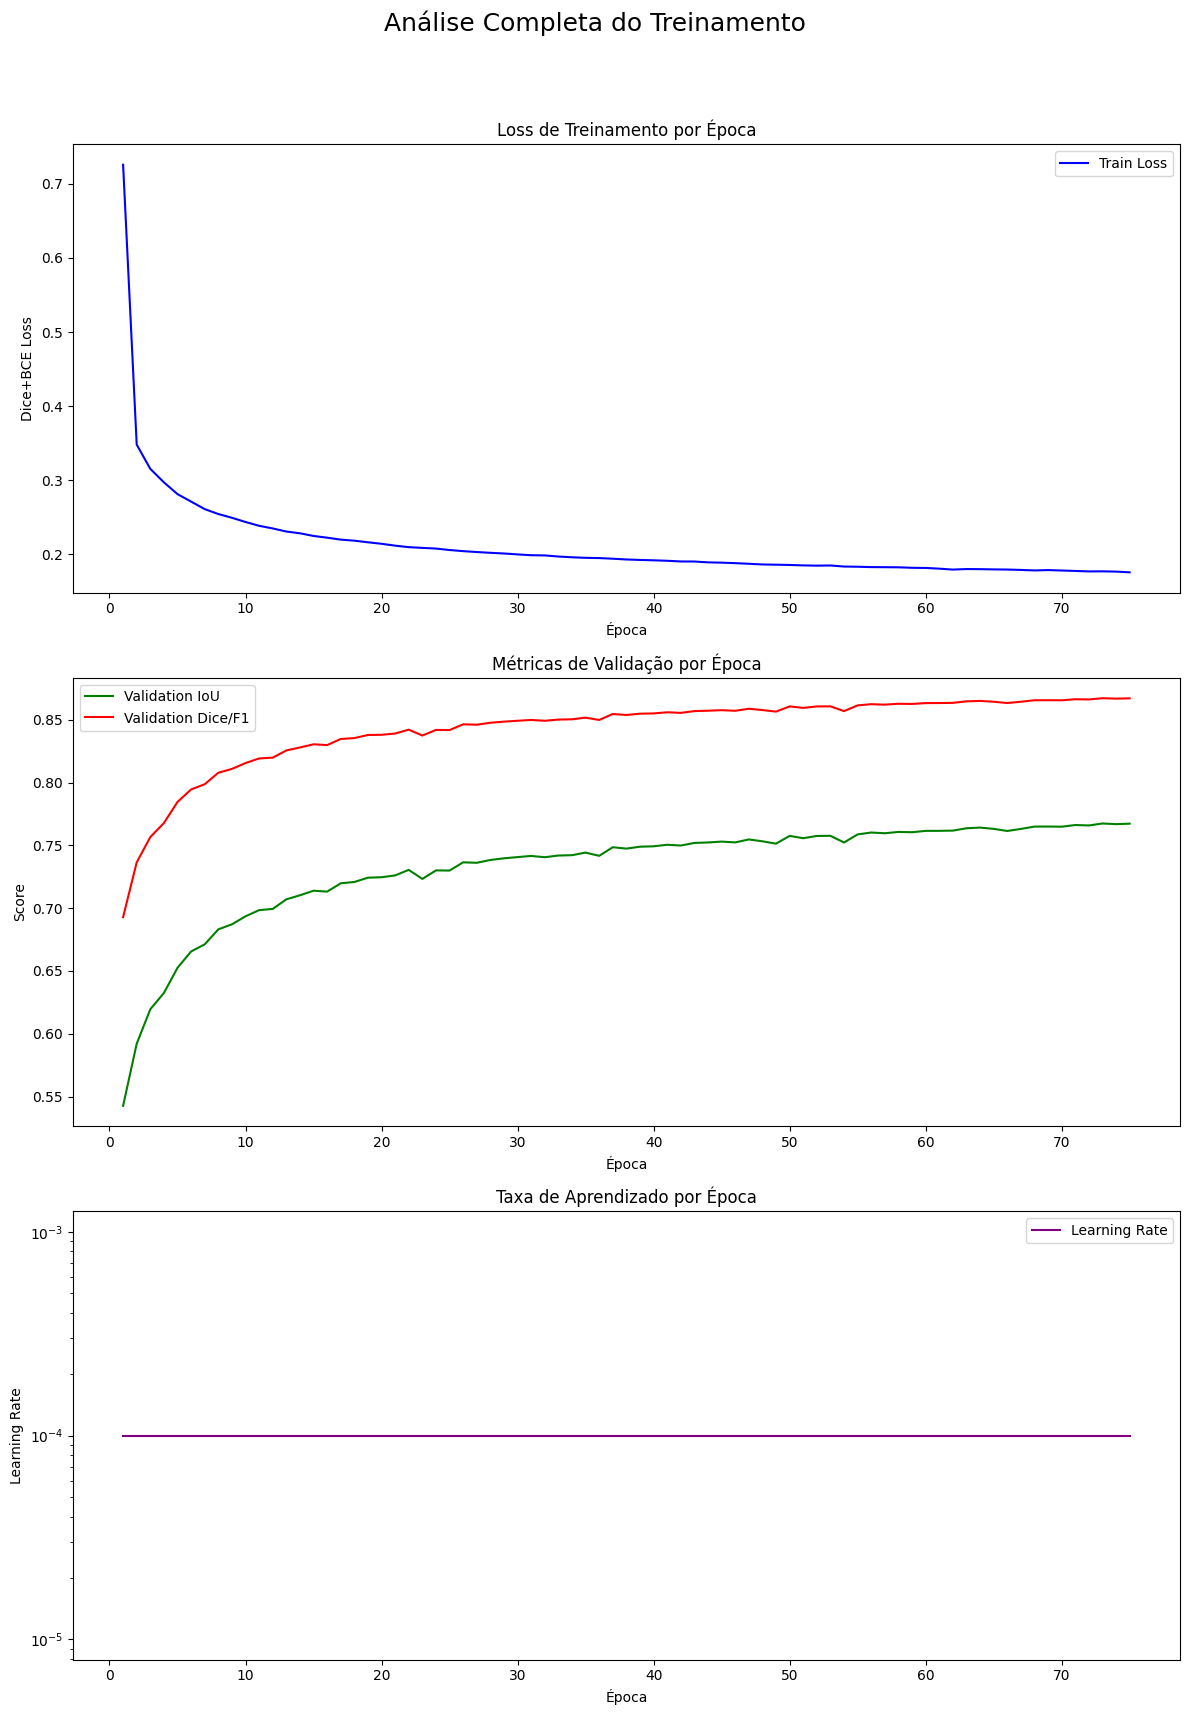


Calculando métricas finais detalhadas no conjunto de validação...


Calculando Métricas Finais: 100%|██████████| 1058/1058 [01:02<00:00, 16.98it/s]



      RESULTADOS FINAIS DO MELHOR MODELO
IoU         : 0.7674
Dice/F1     : 0.8672
Precision   : 0.9117
Recall      : 0.8277

Gerando visualizações de predições do melhor modelo...


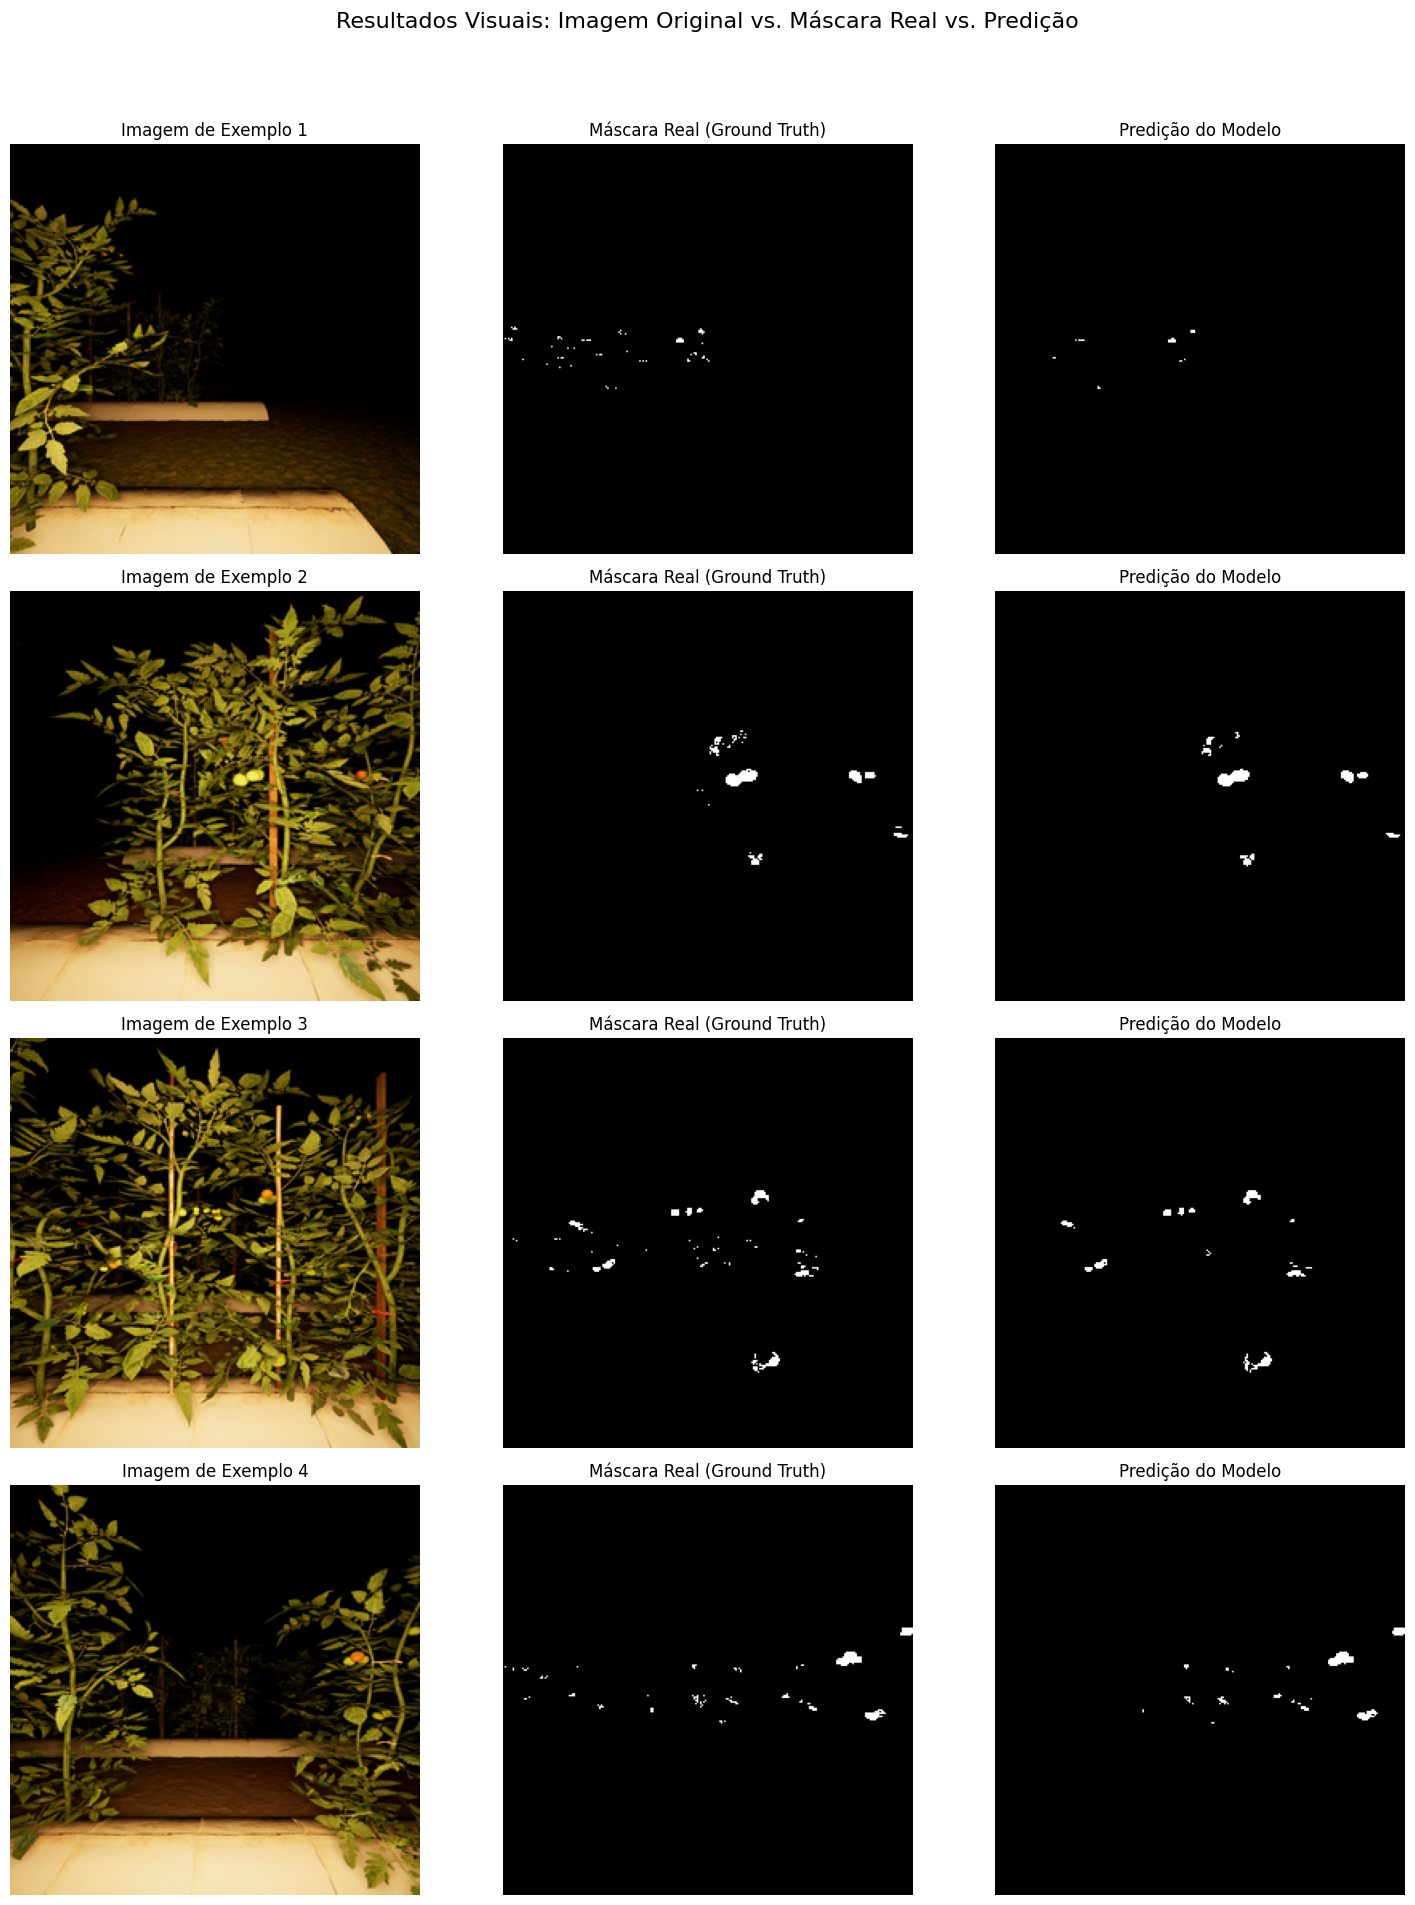

In [9]:
# ===================================================================
# CÉLULA 11: ANÁLISE FINAL, GRÁFICOS E MÉTRICAS (SUBSTITUIR)
# ===================================================================

# --- 1. CARREGAR DADOS E O MELHOR MODELO ---
print(f"Carregando o melhor modelo salvo de '{MODEL_SAVE_PATH}'...")
# Recria a arquitetura do modelo para carregar os pesos
analysis_model = UNET(in_channels=3, out_channels=1).to(DEVICE)
analysis_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
analysis_model.eval() # Coloca o modelo em modo de avaliação definitivo

print(f"Carregando log de treinamento de '{CSV_LOG_PATH}'...")
log_df = pd.read_csv(CSV_LOG_PATH)


# --- 2. GERAR GRÁFICOS DE TREINAMENTO ---
print("Gerando gráficos de treinamento...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise Completa do Treinamento', fontsize=18)

# Gráfico 1: Loss de Treino
sns.lineplot(x='epoch', y='train_loss', data=log_df, ax=ax1, color='blue', label='Train Loss')
ax1.set_title('Loss de Treinamento por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('Dice+BCE Loss')

# Gráfico 2: Métricas de Validação
sns.lineplot(x='epoch', y='val_iou', data=log_df, ax=ax2, color='green', label='Validation IoU')
sns.lineplot(x='epoch', y='val_dice', data=log_df, ax=ax2, color='red', label='Validation Dice/F1')
ax2.set_title('Métricas de Validação por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Score')
ax2.legend()

# Gráfico 3: Taxa de Aprendizado
sns.lineplot(x='epoch', y='learning_rate', data=log_df, ax=ax3, color='purple', label='Learning Rate')
ax3.set_title('Taxa de Aprendizado por Época')
ax3.set_xlabel('Época')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log') # Escala logarítmica para ver melhor as quedas

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. CÁLCULO DE MÉTRICAS FINAIS DETALHADAS ---
def calculate_final_metrics(loader, model, device):
    print("\nCalculando métricas finais detalhadas no conjunto de validação...")
    dice_scores, iou_scores, precisions, recalls = [], [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculando Métricas Finais"):
            x, y = x.to(device), y.to(device)
            if len(y.shape) == 3: y = y.unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            tp = (preds * y).sum()
            fp = ((1 - y) * preds).sum()
            fn = (y * (1 - preds)).sum()
            
            precision = (tp + 1e-6) / (tp + fp + 1e-6)
            recall = (tp + 1e-6) / (tp + fn + 1e-6)
            dice = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)
            iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
            
            precisions.append(precision.item())
            recalls.append(recall.item())
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    final_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice/F1": np.mean(dice_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }
    return final_metrics

final_metrics = calculate_final_metrics(val_loader, analysis_model, DEVICE)


# --- 4. EXIBIR TABELA DE RESULTADOS FINAIS ---
print("\n" + "="*40)
print("      RESULTADOS FINAIS DO MELHOR MODELO")
print("="*40)
for metric, value in final_metrics.items():
    print(f"{metric:<12}: {value:.4f}")
print("="*40 + "\n")


# --- 5. VISUALIZAÇÃO QUALITATIVA DAS PREDIÇÕES ---
print("Gerando visualizações de predições do melhor modelo...")
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
val_images, val_masks = next(iter(val_loader))
num_images = min(5, len(val_images))

fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
fig.suptitle('Resultados Visuais: Imagem Original vs. Máscara Real vs. Predição', fontsize=16)

for i in range(num_images):
    image_tensor = val_images[i].to(DEVICE)
    true_mask_np = val_masks[i].squeeze().cpu().numpy()
    
    with torch.no_grad():
        pred_mask = analysis_model(image_tensor.unsqueeze(0))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask_np = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image_tensor).cpu().permute(1, 2, 0).numpy()

    axs[i, 0].imshow(np.clip(image_display, 0, 1))
    axs[i, 0].set_title(f"Imagem de Exemplo {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask_np, cmap='gray')
    axs[i, 1].set_title("Máscara Real (Ground Truth)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_mask_np, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()